<a href="https://colab.research.google.com/github/Compiler0110/TextExtractionMachineLearning/blob/main/Machine_Learning_Text_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This documentation outlines a Python script designed to perform optical character recognition (OCR) and text extraction from images while employing various image preprocessing techniques. It utilizes libraries such as OpenCV, Google Cloud Vision, and Pillow to enhance image quality and readability, making it particularly effective at extracting text accurately from images.

Prerequisites

In [ ]:
!pip install google-cloud-vision
!pip install --upgrade google-cloud-vision
!pip install pytesseract
!python -m spacy info
!python -m spacy download ro_core_news_sm
!python -m spacy download ro_core_news_lg
!python -m spacy download en_core_web_lg
from google.cloud import vision
from google.cloud import vision_v1
import os,io
import re
import cv2
from PIL import Image
import spacy
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from spacy.matcher import Matcher
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 5.8 MB/s eta 0:00:00


2023-10-03 09:59:30.709535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 09:59:32.584641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

============================== Info about spaCy ==============================

spaCy version    3.6.1                         
Location         /usr/local/lib/python3.10/dist-packages/spacy
Platform         Linux-5.15.120+-x86_64-with-glibc2.35
Python version   3.10.12                       
Pipelines        en_core_web_sm (3.6.0)        

2023-10-03 09:59:42.449281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructi

# Code Overview
This code performs the following main tasks:

Imports necessary libraries and sets up the Google Cloud Vision client for text detection and OCR.

Defines a function resize_image(image, new_size) to resize input images while maintaining their aspect ratio and filling any extra space with white pixels to ensure consistent processing.

Implements an image_prepro(image) function that preprocesses images in the following steps:

Resizes the image.
Normalizes pixel values.
Applies skew correction.
Adjusts the image's resolution.
Denoises the image.
Converts the image to grayscale.
Applies binarization to create a binary image.
Displays the preprocessed image.
Defines a process_image(image_path) function to process a single image:

Reads the image file.
Calls image_prepro() to preprocess the image.
Uses Google Cloud Vision to detect text within the preprocessed image.
Returns the extracted text.
Provides a process_images(image_paths) function to process multiple images and save the results to an Excel file:

Iterates through a list of image file paths.
Calls process_image() for each image.
Stores the results (image path and extracted text) in a Pandas DataFrame.
Exports the DataFrame to an Excel file named 'extracted_text.xlsx'.
In the __main__ block, the code demonstrates how to use the functions:

Specifies a list of image file paths (images) to be processed.
Calls process_image() for an individual image (image).
Prints the extracted text for demonstration purposes.

# Usage

Ensure that you have met all the prerequisites mentioned above, including setting up Google Cloud credentials.

Define the list of image file paths (images) that you want to process.

Execute the code, and it will preprocess the images, extract text using Google Cloud Vision, and display the extracted text.

To process multiple images and save the results to an Excel file, call the process_images() function and provide a list of image file paths as an argument.

# Example Output
When you run the code, it will:

Display the preprocessed images with annotations.
Print the extracted text from individual images.
Save the results, including image file paths and extracted text, to an Excel file named 'extracted_text.xlsx'.
The code's image preprocessing and OCR capabilities contribute to improved text extraction accuracy from images.

# Conclusion

This Python script serves as a valuable tool for extracting text from images with enhanced accuracy. By leveraging various preprocessing techniques and the Google Cloud Vision API, it ensures that text is extracted efficiently and effectively from a range of image sources, making it suitable for tasks such as digitizing documents, extracting information from images, and more.

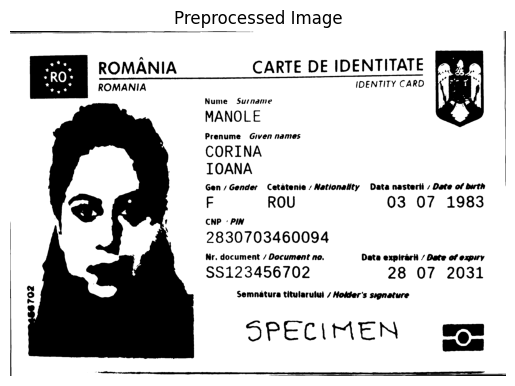

466702
RO
ROMÂNIA
ROMANIA
CARTE DE IDENTITATE
IDENTITY CARD
Nume Surname
MANOLE
Prenume Given names
CORINA
IOANA
Gen / Gender
F
CNP PIN
Cetatenie / Nationality Data nasterii / Date of birth
ROU
03 07 1983
2830703460094
Nr. document / Document no.
SS123456702
Data expirării / Date of expiry
28 07 2031
Semnătura titularului / Holder's signature
SPECIMEN
§


In [ ]:
with open('LICENSE', 'w') as f:
    f.write('''MIT License

Copyright (c) [2023] [Fakher-Aldeen Odeh]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.''')

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'Your API JSON File'

client = vision.ImageAnnotatorClient()
def resize_image(image, new_size=(1134, 788)):

    if isinstance(image, np.ndarray):
        original_size = (image.shape[1], image.shape[0])
    elif isinstance(image, cv2.Mat):
        original_size = (image.cols, image.rows)
    else:
        try:
            image = np.array(image)
            original_size = (image.shape[1], image.shape[0])
        except Exception as e:
            raise ValueError("Unsupported image type. Please provide a NumPy array or OpenCV image.")


    scaling_factor_x = new_size[0] / original_size[0]
    scaling_factor_y = new_size[1] / original_size[1]


    resized_image = cv2.resize(image, None, fx=scaling_factor_x, fy=scaling_factor_y, interpolation=cv2.INTER_CUBIC)


    new_image = np.ones((new_size[1], new_size[0], 3), dtype=np.uint8) * 255


    x_offset = (new_image.shape[1] - resized_image.shape[1]) // 2
    y_offset = (new_image.shape[0] - resized_image.shape[0]) // 2


    new_image[y_offset:y_offset + resized_image.shape[0], x_offset:x_offset + resized_image.shape[1]] = resized_image

    return new_image


def image_prepro(image):

  new_image = resize_image(image)
  normalized_image = np.array(new_image, dtype=np.float32) / 255.0

  skew_angle = 0.5
  rotated_image = cv2.warpAffine(normalized_image, cv2.getRotationMatrix2D((normalized_image.shape[1] / 2, normalized_image.shape[0] / 2), skew_angle, 1.0), normalized_image.shape[1::-1])

  desired_ppi = 300
  current_ppi = 96
  scaling_factor = desired_ppi / current_ppi
  scaled_image = cv2.resize(rotated_image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_CUBIC)

  denoising_image = (scaled_image * 255).astype(np.uint8)

  denoised_image = cv2.fastNlMeansDenoisingColored(denoising_image, None,10, 12, 1, 36)



  gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

  _, binarized_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  plt.imshow(binarized_image, cmap='gray')
  plt.title('Preprocessed Image')
  plt.axis('off')
  plt.show()

  preprocessed_image = vision.Image(content=cv2.imencode('.jpg', binarized_image)[1].tobytes())

  response = client.text_detection(image=preprocessed_image)

  text_annotations = response.text_annotations
  return text_annotations

#function to read single image
def process_image(image_path):
    try:
        with open(image_path, 'rb') as image_file:
            content = image_file.read()

        image = Image.open(image_path)
        text_annotations = image_prepro(image)

        detected_text = text_annotations[0].description if text_annotations else ''
        return detected_text

    except Exception as e:
        print(f"Error processing image '{image_path}': {e}")
        return ''

# Define a function to process multiple images and save the results to an Excel file
def process_images(image_paths):
    extracted_text_data = []

    for image_path in image_paths:
        extracted_text = process_image(image_path)

        extracted_text_data.append({
            'Image File': image_path,
            'Extracted Text': extracted_text
        })

    df = pd.DataFrame(extracted_text_data)


    output_excel_file = 'extracted_text.xlsx'
    df.to_excel(output_excel_file, index=False)
    print(f"Extracted text saved to '{output_excel_file}'")


if __name__ == '__main__':

  try:


    images = ['last image.jpg','image_resize2.jpg']
    image = 'img1.jpg'
    text =  process_image(image)
    print(text)
  except Exception as e:
     raise ValueError(f"the Erorr says :{e}")